In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.signal import find_peaks
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from keras.layers import Dense, Conv1D, Add, Input, Activation, MaxPooling1D, Flatten, Softmax
from keras.models import Model
import tensorflow as tf
np.random.seed(42)

In [2]:
Fs = 50 # Sampling Frequency of My ECG-checker

In [17]:
###############################################################
## Load data
###############################################################
## This is my data from my handmade ECG-checker
df_ = pd.read_csv("ECG_data.csv", header=None)
df_.columns = ["raw"]
raw = "raw"
df_[raw].replace('', np.nan).dropna(inplace=True)
df_ = df_.drop(df_.shape[0]-1)
df_[raw] = df_[raw].astype(float)
df_ = df_[:int(-Fs*0.5)] #delete last 500ms
T_ = np.arange(df_[raw].shape[0]) * 1000 / Fs
df_["Time"] = T_
df_ = df_.set_index("Time")
print(df_)

            raw
Time           
0.0      1904.0
20.0     2030.0
40.0     2078.0
60.0     2118.0
80.0     2115.0
...         ...
13060.0   865.0
13080.0  1930.0
13100.0  1638.0
13120.0  1233.0
13140.0  1237.0

[658 rows x 1 columns]


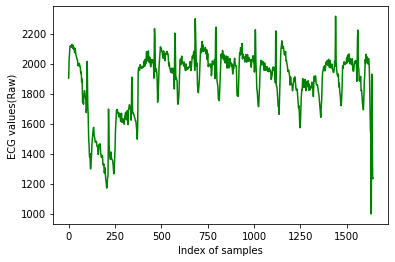

In [20]:
###############################################################
## Pre-Proccessing
###############################################################
## Resampling because samppling rate of training data from MIT is 125[Hz]
f = interpolate.interp1d(df_.index.values, df_[raw].values, kind='linear')
T = np.arange(0, df_.index.values.max(), 1000/125)
Y = f(T)
plt.plot(Y, color='green')
plt.xlabel("Index of samples")
plt.ylabel("ECG values(Raw)")
plt.show()

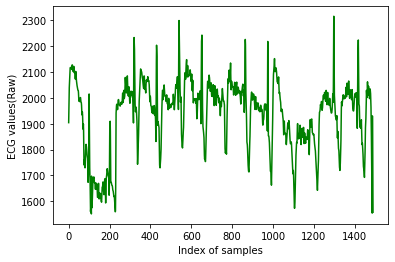

In [21]:
## Delete outlier
df = pd.DataFrame(Y, index=T, columns=["raw"])
df = df[((2048-500)<df[raw]) & (df[raw]<(2048+500))] #2048 is the referential　potential of my handemade ecg-checker
plt.plot(df[raw].values, color='green')
plt.xlabel("Index of samples")
plt.ylabel("ECG values(Raw)")
plt.show()

In [9]:
## Normalization
def normalize(val):
    return (val-np.min(val)) / (np.max(val)-np.min(val))
df["raw_norm"] = normalize(df[raw])
raw = "raw_norm"

## Find R-peak
idx_R_peaks, _ = find_peaks(df[raw].values, height=.8)

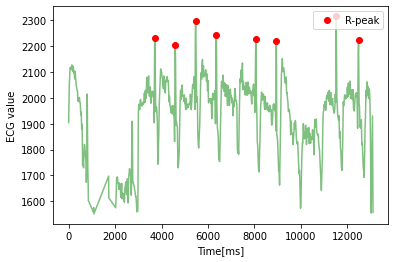

In [22]:
def plot_R_peak(X, Y, idx):
    plt.plot(X, Y, c="green", alpha=0.5)
    plt.plot(X[idx], Y[idx], "ro", label="R-peak")
    plt.xlabel("Time[ms]")
    plt.ylabel("ECG value")
    plt.legend(loc="upper right")
    plt.show()

plot_R_peak(df.index, df[raw].values, idx_R_peaks)

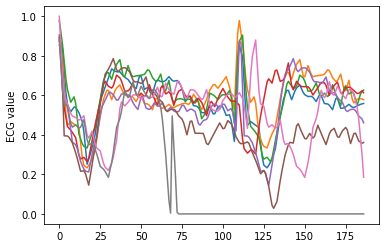

In [13]:

## Divide ECG data along RR_interval
RR_interval = int(np.mean(np.diff(idx_R_peaks)))
def extract_beats(Y, idx_R_peaks, RR_interval, coef=1.2, duration=187):
    beats = []
    RR_interval = int(coef*RR_interval)
    for i in idx_R_peaks:
        beat = np.zeros(duration)
        if i+RR_interval <= Y.shape[0]:
            beat[:RR_interval] = Y[i:i+RR_interval]
        else:
            beat[:Y.shape[0]-i] = Y[i:Y.shape[0]]
        beats.append(beat)
    return beats

beats = extract_beats(df[raw].values, idx_R_peaks, RR_interval)
df_ecg = pd.DataFrame(beats)
for i in range(df_ecg.shape[0]):
    df_ecg.loc[i].plot()

plt.xlabel("Index of samples")
plt.ylabel("ECG value")
plt.show()

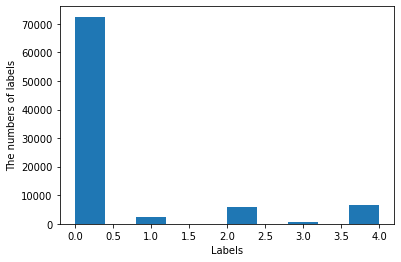

In [24]:
###############################################################
## Deep Learning
###############################################################
# we can download dateset from kaggle
# https://www.kaggle.com/datasets/shayanfazeli/heartbeat

df_train = pd.read_csv("mitbih_train.csv", header=None)
df_test = pd.read_csv("mitbih_test.csv", header=None)

train_X = df_train.values[:, :-1]
train_y = df_train.values[:, -1].astype(int)
test_X = df_test.values[:, :-1]
test_y = df_test.values[:, -1].astype(int)
plt.hist(train_y)
plt.xlabel("Labels")
plt.ylabel("The numbers of labels")
plt.show()

In [26]:
train_X, train_y = shuffle(train_X, train_y, random_state=0)
n_obs, feature = train_X.shape
batch_size =500

In [33]:
## Build a model
I1 = Input(shape=(feature, 1))
C = Conv1D(filters=32, kernel_size=5, strides=1)(I1)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(C)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',)(C11)
S11 = Add()([C12, C])
A11 = Activation('relu')(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A11)

C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(M11)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',)(C21)
S21 = Add()([C22, M11])
A21 = Activation('relu')(S21)
M21 = MaxPooling1D(pool_size=5, strides=2)(A21)

C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(M21)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',)(C31)
S31 = Add()([C32, M21])
A31 = Activation('relu')(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A31)

C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(M31)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',)(C41)
S41 = Add()([C42, M31])
A41 = Activation('relu')(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A41)

C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(M41)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',)(C51)
S51 = Add()([C52, M41])
A51 = Activation('relu')(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A51)

F1 = Flatten()(M51)
D1 = Dense(32, activation='relu')(F1)
D2 = Dense(32)(D1)
D3 = Dense(5)(D2)
A6 = Softmax()(D3)

model = Model(inputs=I1, outputs=A6)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 183, 32)      192         ['input_3[0][0]']                
                                                                                                  
 conv1d_23 (Conv1D)             (None, 183, 32)      5152        ['conv1d_22[0][0]']              
                                                                                                  
 conv1d_24 (Conv1D)             (None, 183, 32)      5152        ['conv1d_23[0][0]']              
                                                                                            

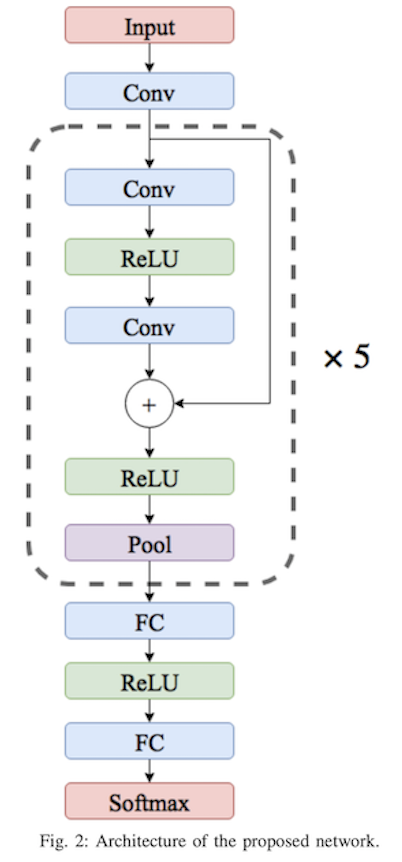

In [34]:
## Train a model and predict
hist = model.fit(train_X, train_y, epochs=75, batch_size=batch_size, verbose=2, validation_data=(test_X,test_y))#,callbacks=[lrate])
pred_test = model.predict(test_X, batch_size=1000)

Epoch 1/75
176/176 - 4s - loss: 0.3642 - accuracy: 0.8951 - val_loss: 0.2478 - val_accuracy: 0.9330 - 4s/epoch - 23ms/step
Epoch 2/75
176/176 - 3s - loss: 0.1344 - accuracy: 0.9635 - val_loss: 0.1368 - val_accuracy: 0.9619 - 3s/epoch - 17ms/step
Epoch 3/75
176/176 - 3s - loss: 0.0964 - accuracy: 0.9734 - val_loss: 0.0966 - val_accuracy: 0.9735 - 3s/epoch - 17ms/step
Epoch 4/75
176/176 - 3s - loss: 0.0812 - accuracy: 0.9775 - val_loss: 0.0866 - val_accuracy: 0.9771 - 3s/epoch - 17ms/step
Epoch 5/75
176/176 - 3s - loss: 0.0713 - accuracy: 0.9797 - val_loss: 0.0829 - val_accuracy: 0.9763 - 3s/epoch - 17ms/step
Epoch 6/75
176/176 - 3s - loss: 0.0666 - accuracy: 0.9810 - val_loss: 0.0774 - val_accuracy: 0.9800 - 3s/epoch - 17ms/step
Epoch 7/75
176/176 - 3s - loss: 0.0595 - accuracy: 0.9828 - val_loss: 0.0952 - val_accuracy: 0.9727 - 3s/epoch - 17ms/step
Epoch 8/75
176/176 - 3s - loss: 0.0587 - accuracy: 0.9829 - val_loss: 0.0709 - val_accuracy: 0.9805 - 3s/epoch - 17ms/step
Epoch 9/75
176/1

In [35]:
## Evaluate a model
print(classification_report(test_y, pred_test.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.93      0.80      0.86       556
           2       0.98      0.94      0.96      1448
           3       0.88      0.76      0.82       162
           4       0.98      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.90      0.92     21892
weighted avg       0.99      0.99      0.99     21892



In [29]:
## Prediction by my ECG data
pred = model.predict(df_ecg.values, batch_size=1000)
print(pred.argmax(axis=1))

[0 2 0 0 2 2 0 0]


In [36]:
print("No way! I am helth conscious, or should I go to a hospital?")

#REF:
#https://arxiv.org/pdf/1805.00794.pdf

No way! I am helth conscious, or should I go to a hospital?
